#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
sp500 = pd.read_csv("/workspaces/codespaces-jupyter/data/SP500_2006_16_data.csv")
sp500# sp500 = pd.read_csv("https://osf.io/h64z2/download")

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82
...,...,...
2606,2016-08-22,2182.64
2607,2016-08-23,2186.90
2608,2016-08-24,2175.44
2609,2016-08-25,2172.47


In [4]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [5]:
#Fractional change between the current and a prior element. Examples below
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

In [6]:
#Fractial change in action
s = pd.Series([90, 91, None, 85])
s.ffill().pct_change()

0         NaN
1    0.011111
2    0.000000
3   -0.065934
dtype: float64

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

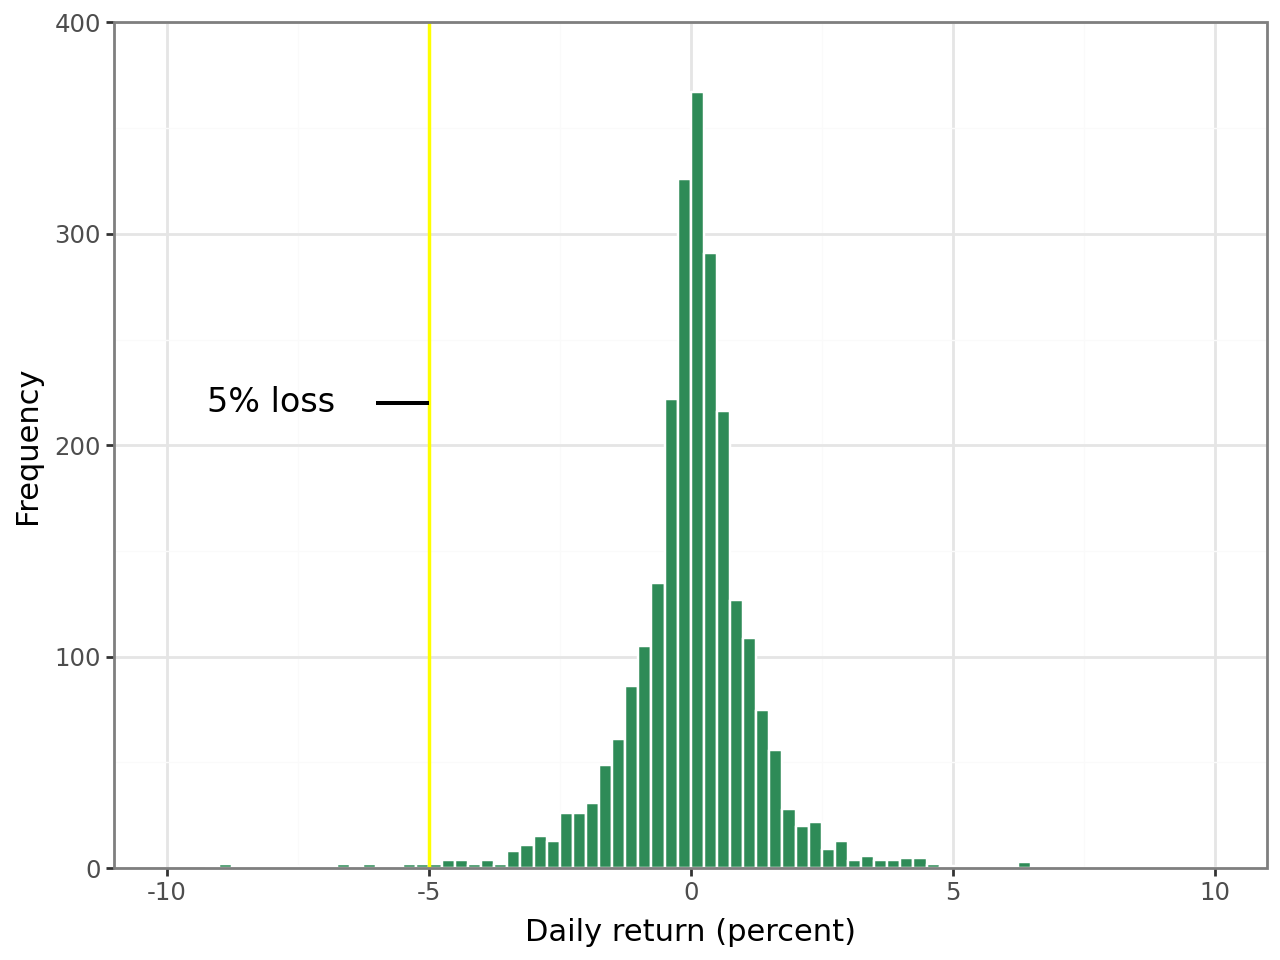

In [8]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill="seagreen", boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color="yellow")
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [9]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

In [10]:
sp500max=sp500.loc[sp500["pct_return"].idxmax()]
sp500max

DATE          2008-10-13 00:00:00
VALUE                     1003.35
pct_return              11.580036
year                         2008
month                          10
yearmonth                  200810
Name: 536, dtype: object

In [11]:
sp500.count()
sp500
sp500less5 = sp500.loc[sp500["pct_return"] < -5].reset_index(drop=True)
sp500less5["pct_return_decimal"] = sp500less5["pct_return"] / 100
sp500less5

,DATE,VALUE,pct_return,year,month,yearmonth,pct_return_decimal
0,2008-09-29,1106.39,-8.789705,2008,9,200809,-0.087897
1,2008-10-07,996.23,-5.739481,2008,10,200810,-0.057395
2,2008-10-09,909.92,-7.616708,2008,10,200810,-0.076167
3,2008-10-15,907.84,-9.034980,2008,10,200810,-0.090350
4,2008-10-22,896.78,-6.101251,2008,10,200810,-0.061013
5,2008-11-05,952.77,-5.267711,2008,11,200811,-0.052677
6,2008-11-06,904.88,-5.026397,2008,11,200811,-0.050264
7,2008-11-12,852.30,-5.189388,2008,11,200811,-0.051894
8,2008-11-19,806.58,-6.115560,2008,11,200811,-0.061156
9,2008-11-20,752.44,-6.712291,2008,11,200811,-0.067123


In [12]:
sp500less5['DATE'].min(), sp500less5['DATE'].max()

(Timestamp('2008-09-29 00:00:00'), Timestamp('2011-08-08 00:00:00'))

In [13]:
sp500less5["pct_return"].mean()

np.float64(-6.65138836502497)

In [14]:
true_share = (sp500["pct_return"] <= -5).mean()
print(true_share)

0.005160778086542279


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [15]:
from importlib import import_module

# Try to import create_sample_frame from the func directory
create_sample = import_module("func_sample")  # replace with actual filename without .py
create_sample_frame = create_sample.create_sample_frame

help(create_sample_frame)

ModuleNotFoundError: No module named 'func_sample'

In [16]:
n_samples = 10000  # Define the number of samples

# For n=1000
samples_1000 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 1000), replace=True)
a=samples_1000 < -5

nobs_1000 = np.mean(samples_1000 < -5, axis=1)

# For n=500
samples_500 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 500), replace=True)
nobs_500 = np.mean(samples_500 < -5, axis=1)


In [17]:
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000})*100

In [19]:
a = pd.DataFrame(samples_1000).T
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-2.464265,-2.347303,0.166512,0.348805,-2.256416,-0.030489,-1.050182,1.046818,0.038923,-0.033999,...,0.211889,0.098557,-0.706931,-0.039005,-4.029077,-1.646792,-0.720655,-0.810034,0.271211,-0.999773
1,0.877251,0.197969,0.002846,-0.023783,0.558421,0.660874,0.014979,0.764405,0.443977,0.275938,...,2.950677,-0.031423,-0.174565,0.176142,1.547392,-0.426166,-1.324856,1.283157,0.194036,0.759743
2,1.107890,0.051508,-0.805232,-4.713289,0.499204,0.147412,-0.392356,1.249967,0.521147,0.348805,...,-0.184480,0.330591,0.211095,0.168430,-0.012820,-0.587672,0.809531,-0.737808,-2.806465,0.021259
3,1.296247,0.712106,0.405142,-0.126859,-1.646792,-1.065784,-2.036826,0.668050,2.950677,0.161521,...,1.493015,0.310889,-0.623913,0.034830,-0.607025,-0.487598,1.342345,0.068479,0.209566,0.322341
4,-0.640678,-2.497415,0.173005,-2.116273,0.177394,4.072862,0.979669,1.089441,0.395893,-1.500899,...,0.888577,0.670718,0.724373,-2.323870,-0.971743,-7.616708,1.535733,2.456653,0.372514,0.006355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.398861,-0.150159,-0.256408,-0.337932,0.801462,0.382125,3.412494,0.898492,-0.458122,11.580036,...,0.009172,0.439480,-0.115009,1.046818,-0.850636,0.091950,-0.054574,-0.720655,0.322341,-0.321651
996,-0.322810,0.116478,1.526767,2.052576,0.908089,0.424837,0.430236,0.080025,1.370548,-0.398542,...,0.795493,0.531810,0.005000,-0.768163,1.603589,0.173005,-0.474516,1.183993,1.414431,0.523029
997,-0.358823,-6.712291,-0.400447,0.516566,-1.105000,0.712659,0.545270,0.435034,-1.530378,0.409432,...,-0.030327,-1.014457,0.212161,0.261662,-0.011893,0.111935,-0.618808,0.383594,0.450414,-0.297074
998,0.063594,0.255644,0.004837,-0.943272,6.921272,0.005311,0.523029,0.392539,0.256845,0.002168,...,0.068479,-2.939048,-1.172575,0.015584,2.144427,0.194036,0.194868,-0.126859,-1.968355,1.519015


In [20]:
nobs_df

,nobs_500,nobs_1000
0,0.8,0.4
1,0.2,0.5
2,0.6,0.3
3,0.8,0.5
4,0.2,0.5
...,...,...
9995,0.8,1.4
9996,0.4,0.1
9997,0.4,0.8
9998,0.6,0.4


In [21]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

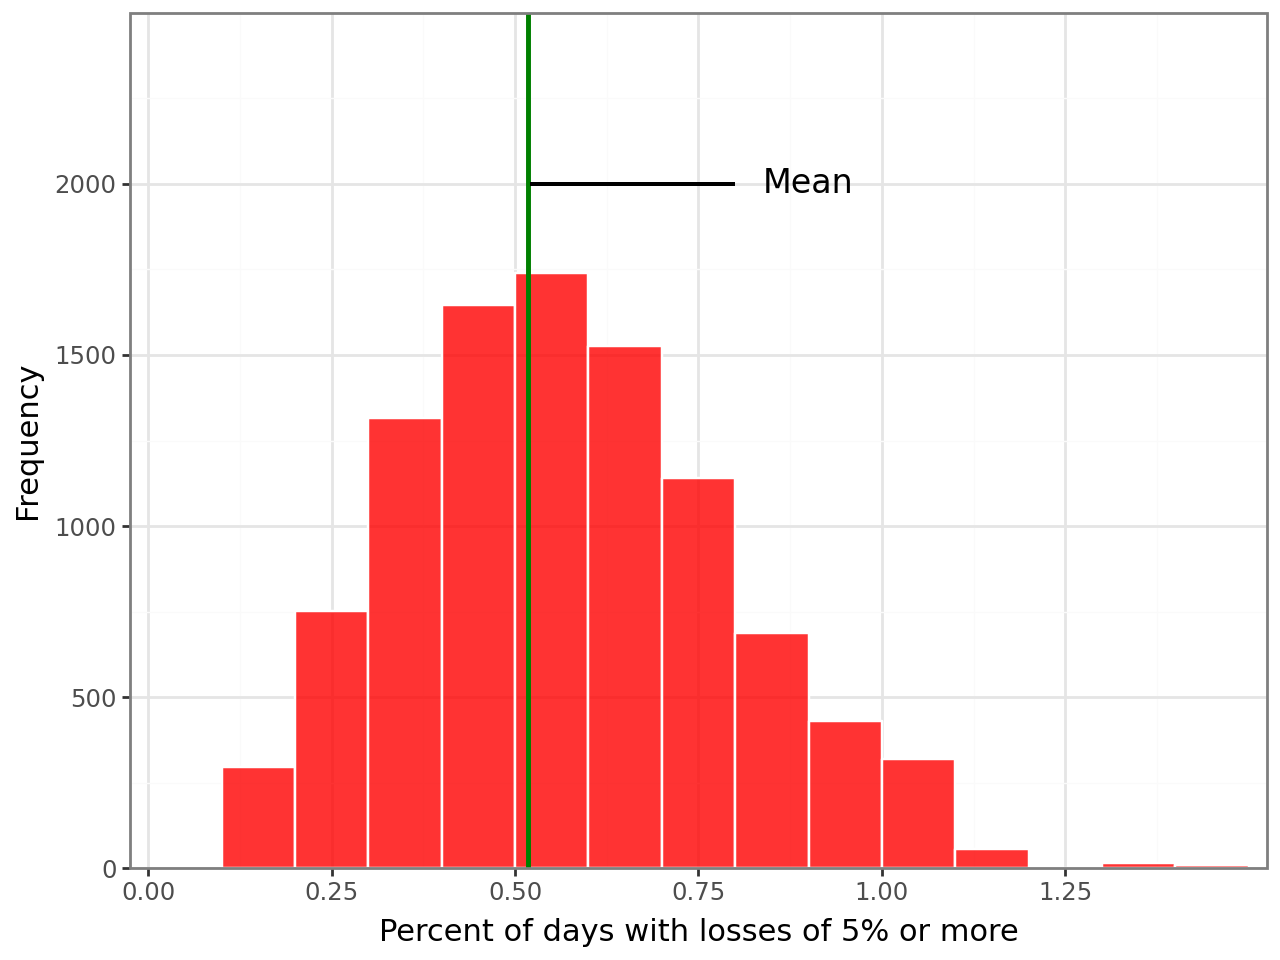

In [22]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill="red",
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color="green", size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=np.arange(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

In [23]:
nobs_df["nobs_1000"].std()

np.float64(0.228896547293611)

In [24]:
nobs_df["nobs_500"].std()

np.float64(0.3223151270171948)

In [25]:
nobs_df["nobs_1000"].mean()

np.float64(0.5181)

In [26]:
nobs_df["nobs_500"].mean()

np.float64(0.51426)

### Figure 5.3 

Not working with epanechnikov kernel

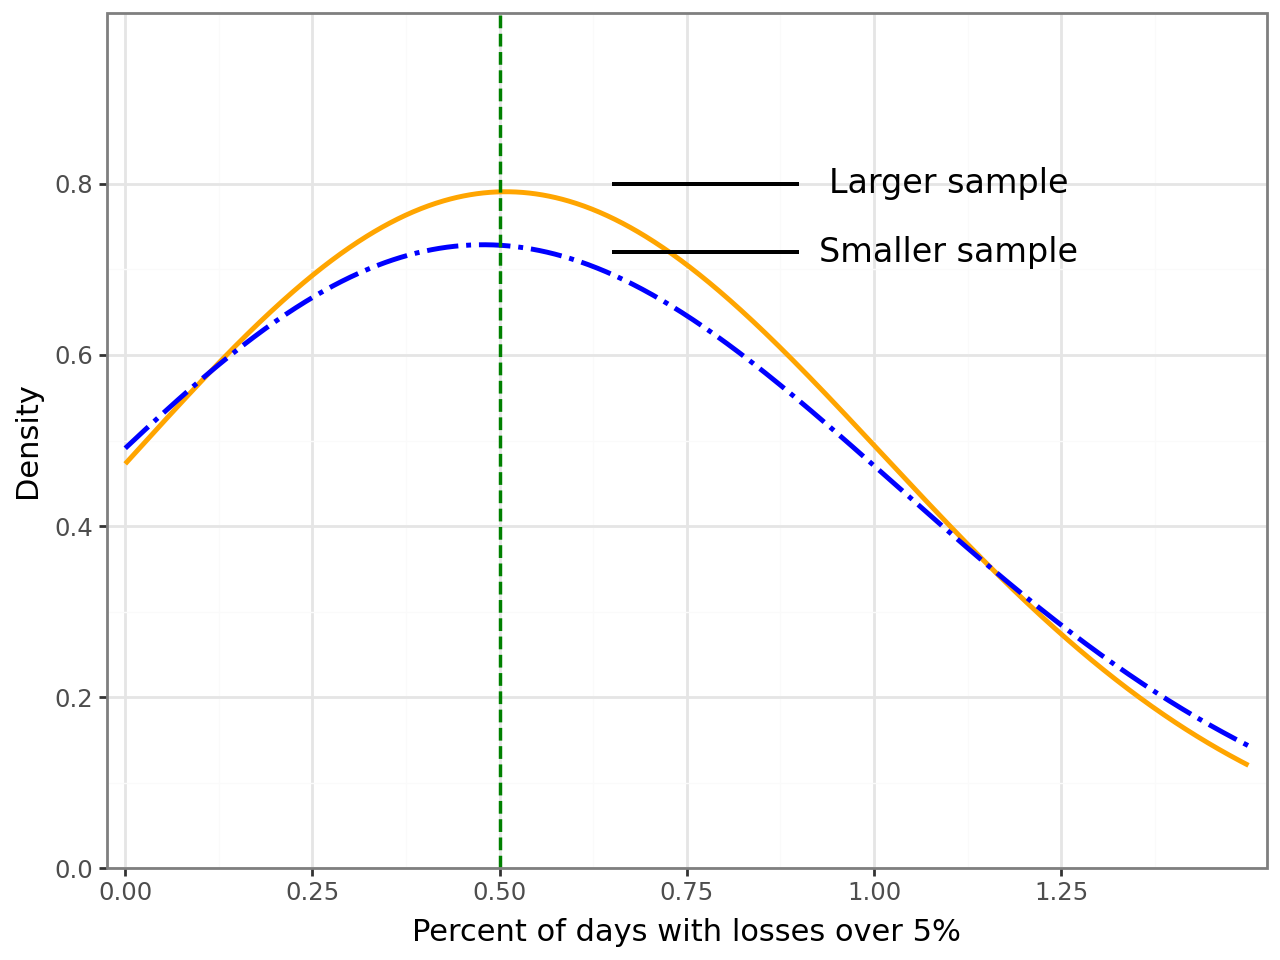

In [27]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color="orange", geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color="blue",
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color="green", size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=np.arange(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

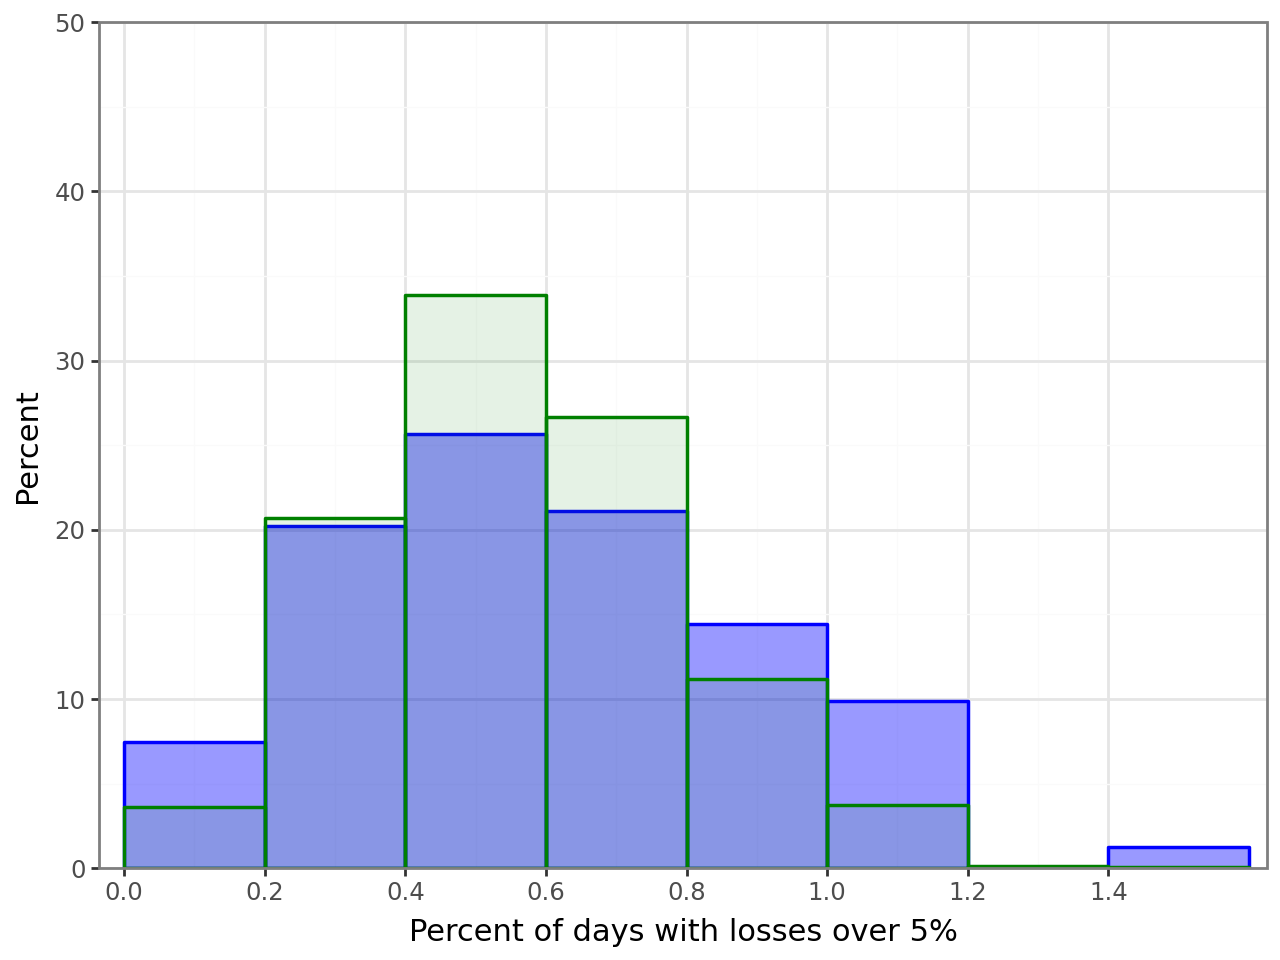

In [28]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color="blue",
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color="green",
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=np.arange(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=("blue", "green")
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [31]:
bootstrap_samples = np.random.choice(
    sp500["pct_return"].dropna(),
    size=(10000, len(sp500["pct_return"].dropna())),
    replace=True
)

In [45]:
pd.DataFrame(bootstrap_samples).T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.989149,-0.187016,1.677226,0.304503,0.363128,-2.004481,0.057490,1.370548,0.870537,1.207547,...,1.283134,0.091095,-0.634261,0.358029,-0.850362,-0.762359,-0.033297,-3.669509,0.588902,-0.057497
1,-1.428156,-1.793374,-3.451124,-0.174565,0.811426,-0.007533,-0.045697,-1.075015,-1.230115,-1.689438,...,0.105109,-0.989149,0.027052,0.030958,-0.193212,0.459808,0.110574,-0.973388,-0.093951,0.018708
2,0.570051,-0.034685,1.092299,0.397388,0.308450,0.718601,-0.136524,-0.272257,0.645470,-1.175928,...,0.187121,0.219959,-0.735155,-1.417393,0.102875,-0.539549,-0.010645,0.222186,-0.012924,0.378665
3,0.060876,-2.347303,-2.130302,0.304796,0.110625,0.294990,-0.134769,0.254842,-0.012820,-0.613166,...,-0.307315,-1.723346,-1.145103,-0.031423,-2.130302,0.189166,0.006355,0.194868,0.148515,-1.342149
4,-0.574588,-0.136176,-0.810034,-0.223256,0.066946,0.536711,1.183993,-2.052851,-0.409251,0.605109,...,1.512159,1.131484,-0.271900,-0.312315,0.805832,0.394699,-0.517661,0.066335,0.192476,0.215820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,-0.424219,0.250321,0.445323,-0.101891,-0.833128,-0.282798,-0.956155,0.721960,0.261737,-0.119862,...,0.684628,-0.758921,1.777020,0.065879,0.655076,-0.456299,-0.527787,0.271162,0.734577,0.798361
2514,0.564065,0.044823,0.568323,-0.973388,-0.055134,1.361579,2.160999,1.033782,-2.581044,0.477271,...,1.907552,-1.031077,1.431527,0.485314,-1.297917,-0.338044,-0.127514,-1.897114,-1.134834,1.097604
2515,-0.256408,0.120986,0.527796,0.350321,0.492201,6.472257,0.310889,0.822003,0.427206,0.234695,...,-2.036826,0.668386,0.541125,0.054520,-1.352201,1.171292,1.070708,0.222031,1.520980,-0.704877
2516,0.409212,-1.065784,0.131403,-0.077911,0.853171,-2.936978,0.961366,1.536543,1.426616,-0.682931,...,-0.159267,6.366310,0.194868,0.697475,-1.716525,0.033849,0.565791,0.669110,-0.147982,-0.127514


Calculate percent of days wit losses over  thresholds from -1 to 10

In [ ]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

In [37]:
bootstrap_loss_results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,13.621922,4.249404,1.548848,0.675139,0.436855,0.198570,0.119142,0.079428,0.079428,0.0
1,14.853058,5.877681,2.541700,1.231136,0.635425,0.357427,0.039714,0.039714,0.000000,0.0
2,13.105639,5.003971,1.826847,0.873709,0.516283,0.397141,0.198570,0.198570,0.039714,0.0
3,15.170770,5.798253,1.866561,0.833995,0.516283,0.238284,0.119142,0.079428,0.079428,0.0
4,14.535346,5.361398,2.303415,1.469420,0.555997,0.357427,0.198570,0.158856,0.079428,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,14.058777,6.036537,2.343129,1.231136,0.794281,0.516283,0.198570,0.119142,0.079428,0.0
9996,14.376489,5.162828,2.382844,1.310564,0.635425,0.476569,0.277998,0.277998,0.119142,0.0
9997,13.105639,5.440826,2.184273,1.231136,0.516283,0.317712,0.198570,0.158856,0.039714,0.0
9998,13.621922,5.242256,1.826847,0.913423,0.476569,0.277998,0.079428,0.039714,0.000000,0.0


Plot percent of days with losses over -5%

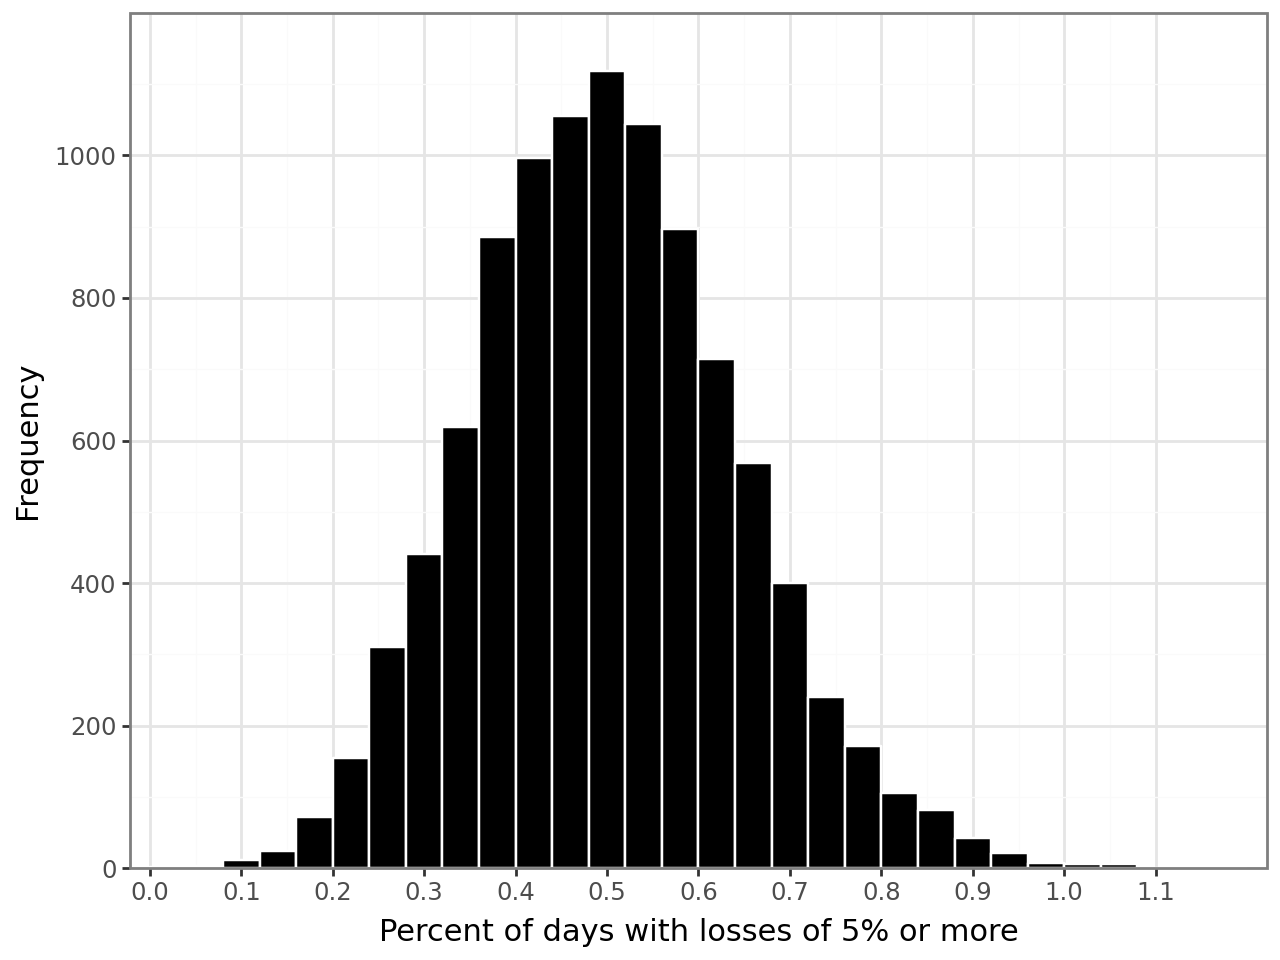

In [36]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)


In [40]:
bootstrap_loss_results.std()

loss1     0.691601
loss2     0.443619
loss3     0.281130
loss4     0.200547
loss5     0.144390
loss6     0.113403
loss7     0.080351
loss8     0.069957
loss9     0.040206
loss10    0.000000
dtype: float64

In [46]:
# Assuming bootstrap_loss_results["loss5"] is a Series of bootstrap results
ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


95% Confidence Interval: [0.2383, 0.8340]


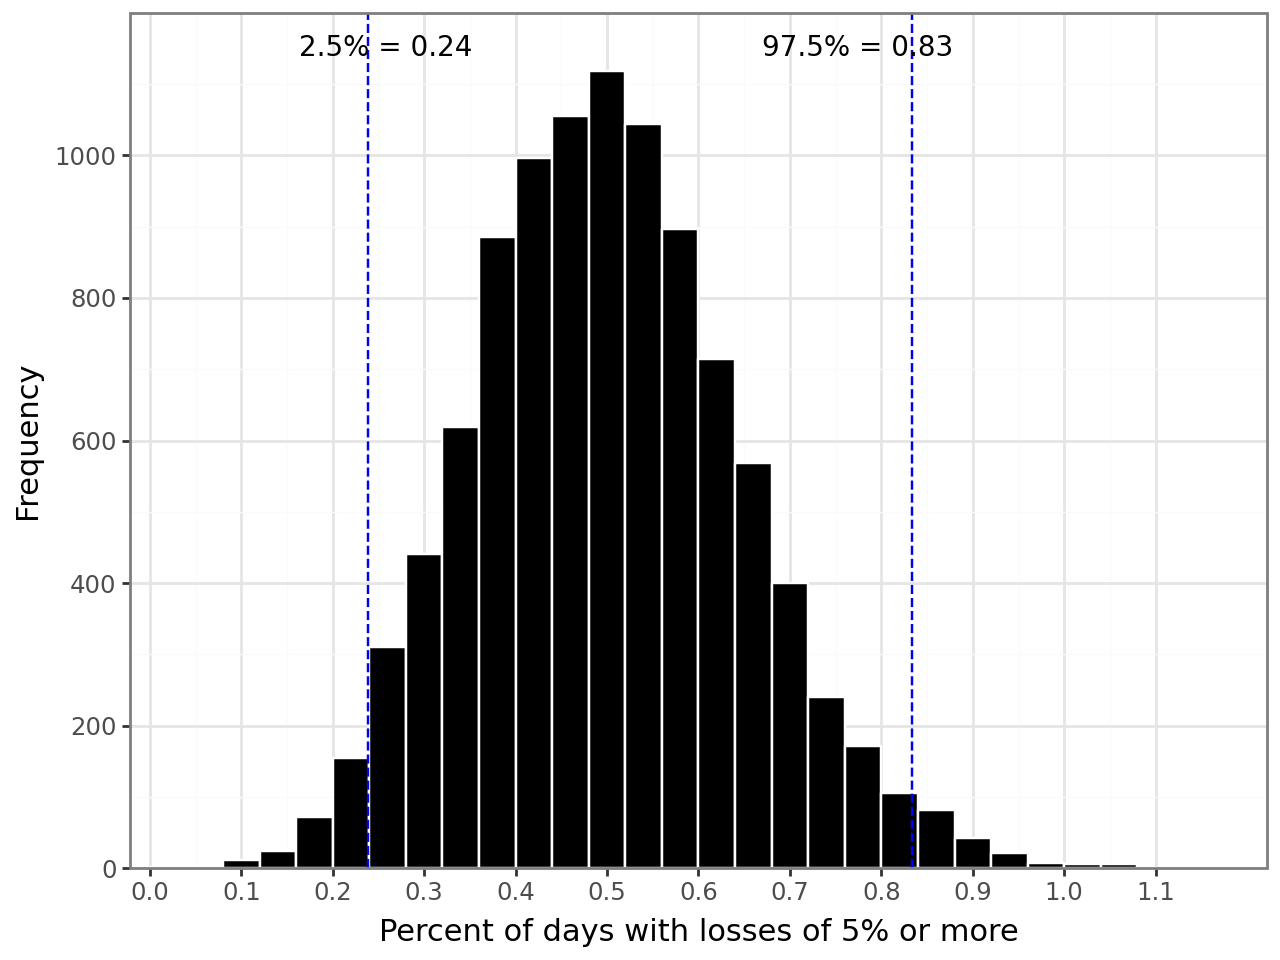

In [47]:
from plotnine import geom_vline, annotate

ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + geom_vline(xintercept=ci_lower, color="blue", linetype="dashed")
    + geom_vline(xintercept=ci_upper, color="blue", linetype="dashed")
    + annotate("text", x=ci_lower + 0.02, y=1150, label=f"2.5% = {ci_lower:.2f}", size=10)
    + annotate("text", x=ci_upper - 0.06, y=1150, label=f"97.5% = {ci_upper:.2f}", size=10)
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
